> ### Human activity Recognition 분류
>   > ###### 분류: 지도학습의 대표적인 예. 학습 데이터로 주어진 데이터의 feature와 label 값을 머신러닝 알고리즘으로 학습해 모델을 생성하고, 이렇게 생선된 모델에 새로운 데이터 값이 주어졌을 때 미지의 레이블 값을 예측하는 것.


> #### 분류를 구현할 알고리즘
- Decision Tree
- 앙상블 학습 - 보팅 분류기 (+ 로지스틱 회귀, SupportVectorMachine, KNeighbors 분류기)
- Random Forest


- 필요한 프로그램 불러오기 + feature name 확인

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
feature_name_df = pd.read_csv('/Users/kimhansaem/workspace/01.MachineLearning/03.분류/human_activity/features.txt', sep='\s+', header=None,
                                names=['column_index', 'column_name'])

feature_name = feature_name_df['column_name'].values.tolist()
print(feature_name[:20])

['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X', 'tBodyAcc-max()-Y', 'tBodyAcc-max()-Z', 'tBodyAcc-min()-X', 'tBodyAcc-min()-Y', 'tBodyAcc-min()-Z', 'tBodyAcc-sma()', 'tBodyAcc-energy()-X', 'tBodyAcc-energy()-Y', 'tBodyAcc-energy()-Z', 'tBodyAcc-iqr()-X']


- duplicate 데이터 개수 확인 : 42개

In [101]:
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


- 42개의 중복된 피처명에 _1 or_2 추가 부여하여 데이터프레임 새로 만듦 (교재 p204)

In [102]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data = old_feature_name_df.groupby('column_name').cumcount(), 
                        columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name']=new_feature_name_df[['column_name',
                    'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
                      if x[1] > 0 else x[0], axis =1)
    
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

- train 디렉토리에 있는 학습용 피처 데이터셋, 레이블 데이터셋
- test 디렉토리에 있는 테스트용 피처 데이터셋, 레이블 데이터셋을 각각 학습/ 테스트용 DF에 로드

In [103]:
# sep 은 공백 문자 입력. 
def get_human_dataset():
    feature_name_df = pd.read_csv('/Users/kimhansaem/workspace/01.MachineLearning/03.분류/human_activity/features.txt', sep='\s+',
                        header=None, names=['column_index', 'column_name'])
    
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()

    X_train = pd.read_csv('/Users/kimhansaem/workspace/01.MachineLearning/03.분류/human_activity/train/X_train.txt', 
                         sep='\s+', names=feature_name)
    X_test = pd.read_csv('/Users/kimhansaem/workspace/01.MachineLearning/03.분류/human_activity/test/X_test.txt', 
                         sep='\s+', names=feature_name)
    y_train = pd.read_csv('/Users/kimhansaem/workspace/01.MachineLearning/03.분류/human_activity/train/y_train.txt', 
                         sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('/Users/kimhansaem/workspace/01.MachineLearning/03.분류/human_activity/test/y_test.txt', 
                         sep='\s+', header=None, names=['action'])
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()


- 로드한 학습용 피처 데이터셋 정보 확인

In [104]:
print('##학습 피쳐 데이터셋 info()')
print(X_train.info())
# 7352개의 레코드로 561개의 feature을 가지고 있음

##학습 피쳐 데이터셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [105]:
X_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [106]:
y_train.head()

,action
0,5
1,5
2,5
3,5
4,5


In [205]:
print(y_train['action'].value_counts())


# 참고) 각각의 액션 레이블은 다음을 뜻한다.
# 1. WALKING
# 2. WALKING_UPSTAIRS
# 3. WALKING_DOWNSTAIRS
# 4. SITTING
# 5. STANDING
# 6. LAYING
# LAYING 액션이 인식된 경우가 가장 많은듯

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


> DecisionTree로 학습한 후 성능 확인

In [108]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()

dtc.fit(X_train, y_train)
print(dtc.score(X_test, y_test))

0.8551068883610451


In [109]:
dtc.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

- GridSearchCV로 교차검증

In [127]:
from sklearn.model_selection import GridSearchCV

params= {
    "max_depth": [8,11,14,17,20,23]
}

grid_dt = GridSearchCV(dtc, param_grid=params, scoring='accuracy', cv=4)
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [8, 11, 14, 17, 20, 23]},
             scoring='accuracy')

In [128]:
print('GridSearchCV 최고 하이퍼 파라미터', grid_dt.best_params_)
print('GridSearchCV 최고 평균 정확도 수치: {0:4f}'.format(grid_dt.best_score_))

GridSearchCV 최고 하이퍼 파라미터 {'max_depth': 8}
GridSearchCV 최고 평균 정확도 수치: 0.851877


- 파라미터에 따라 어떻게 예측 성능이 변했는지 확인

In [129]:
Grid_df = pd.DataFrame(grid_dt.cv_results_)
Grid_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,8,0.851877
1,11,0.848205
2,14,0.838411
3,17,0.834739
4,20,0.843988
5,23,0.839771


- 학습된 모델이 제공하는 정보 중 중요도가 높은 순으로 10개를 그래프로 표현
- tgravityAcc-min()-X, tBodyAccjerk-bandsEnergy()-1,16 등의 피처가 높은 중요도를 갖는다.

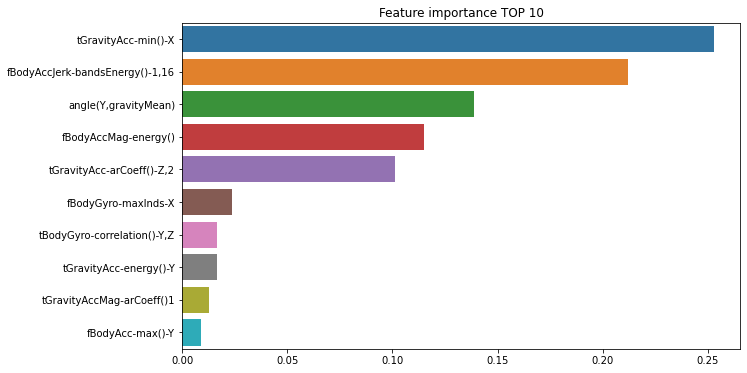

In [132]:
import seaborn as sns
best_dt = grid_dt.best_estimator_
feature_imp = best_dt.feature_importances_
# Series로 변환
ftr_importances = pd.Series(feature_imp, index=X_train.columns)
# 중요도 순으로 Series 정렬
best10 = ftr_importances.sort_values(ascending=False)[:10]
plt.figure(figsize=(10,6))
plt.title("Feature importance TOP 10")
sns.barplot(x=best10, y=best10.index)
plt.show()

> GBM으로 학습 후 성능 확인..하려고 했으나 시간이 너무 오래 걸려서 중단 ㅠ

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=0)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print(gb_accuracy)

> 앙상블 학습 - [보팅 분류기]로 학습 후 성능 확인

In [118]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [120]:
lrc = LogisticRegression()
knn = KNeighborsClassifier()
svc = SVC()
# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기
voc = VotingClassifier(estimators=[('LRC',lrc),('SVC',svc),('KNN',knn)], voting ='hard')

X_train, X_test, y_train, y_test = get_human_dataset()

voc.fit(X_train, y_train)
pred = voc.predict(X_test)
print ('보팅 분류기 정확도: {0:4f}'.format(accuracy_score(y_test,pred)))

# 개별 모델의 학습/ 예측/ 평가
classifiers = [lrc, svc, knn]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} 정확도: {1:4f}'.format(class_name, accuracy_score(y_test, pred)))


보팅 분류기 정확도: 0.954530
LogisticRegression 정확도: 0.958263
SVC 정확도: 0.950458
KNeighborsClassifier 정확도: 0.901595


In [122]:
df = pd.DataFrame(
    {'lrc분류기 정확도':lrc.score(X_test, y_test), 
     '서포트벡터머신 정확도': svc.score(X_test, y_test), 
     'K 최근접이웃 정확도': knn.score(X_test, y_test), 
     '보팅분류기 정확도': voc.score(X_test, y_test)
    }, index=[0])
df.head()

,lrc분류기 정확도,서포트벡터머신 정확도,K 최근접이웃 정확도,보팅분류기 정확도
0,0.958263,0.950458,0.901595,0.95453


> 랜덤포레스트(bagging 방식)로 학습 후 성능 확인

In [123]:
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings(action='ignore')
rfc = RandomForestClassifier(random_state=2021)
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2021,
 'verbose': 0,
 'warm_start': False}

In [126]:
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)
print('랜덤 포레스트 정확도 : {0:.4f}'.format(rfc.score(X_test, y_test)))

랜덤 포레스트 정확도 : 0.9250


In [133]:
from sklearn.model_selection import GridSearchCV

params= {
    "max_depth": [4, 6, 8, 10, 12]
}

grid_rf = GridSearchCV(dtc, param_grid=params, scoring='accuracy', cv=4)
grid_rf.fit(X_train, y_train)
print('GridSearchCV 최고 하이퍼 파라미터', grid_rf.best_params_)
print('GridSearchCV 최고 평균 정확도 수치: {0:4f}'.format(grid_rf.best_score_))

GridSearchCV 최고 하이퍼 파라미터 {'max_depth': 8}
GridSearchCV 최고 평균 정확도 수치: 0.852421


- 파라미터에 따라 어떻게 예측 성능이 변했는지 확인

In [206]:
Grid_df2 = pd.DataFrame(grid_rf.cv_results_)
Grid_df2[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,4,0.846028
1,6,0.842900
2,8,0.852421
3,10,0.843716
4,12,0.839635


- 학습된 모델이 제공하는 정보 중 중요도가 높은 순으로 10개를 그래프로 표현
- tgravityAcc-min()-X, tBodyAcc-mad()-X 등의 피처가 높은 중요도를 갖는다.

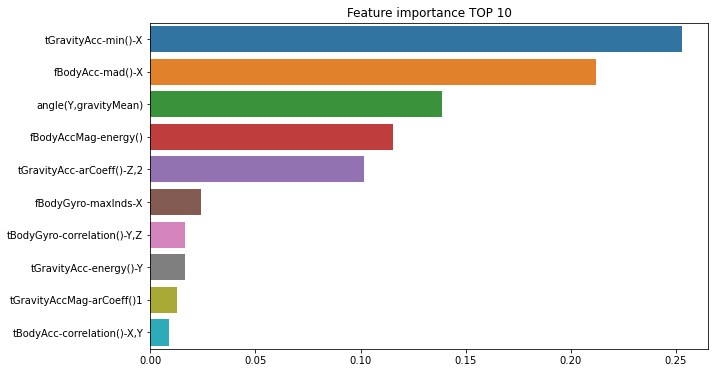

In [134]:
best_rf = grid_rf.best_estimator_
feature_imp = best_rf.feature_importances_
# Series로 변환
ftr_importances = pd.Series(feature_imp, index=X_train.columns)
# 중요도 순으로 Series 정렬
best10 = ftr_importances.sort_values(ascending=False)[:10]
plt.figure(figsize=(10,6))
plt.title("Feature importance TOP 10")
sns.barplot(x=best10, y=best10.index)
plt.show()

> ### 결론

In [137]:
df2 = pd.DataFrame(
    {'lrc분류기 정확도':lrc.score(X_test, y_test), 
     '서포트벡터머신 정확도': svc.score(X_test, y_test), 
     'K 최근접이웃 정확도': knn.score(X_test, y_test), 
     '보팅분류기 정확도':voc.score(X_test, y_test), 
     '랜덤포레스트 정확도': rfc.score(X_test, y_test),
     'decision tree 정확도': dtc.score(X_test, y_test)},
     index=[0]
)
df2.head()

,lrc분류기 정확도,서포트벡터머신 정확도,K 최근접이웃 정확도,보팅분류기 정확도,랜덤포레스트 정확도,decision tree 정확도
0,0.958263,0.950458,0.901595,0.95453,0.925008,0.855107


In [173]:
df2.columns

Index(['lrc분류기 정확도', '서포트벡터머신 정확도', 'K 최근접이웃 정확도', '보팅분류기 정확도', '랜덤포레스트 정확도',
       'decision tree 정확도'],
      dtype='object')

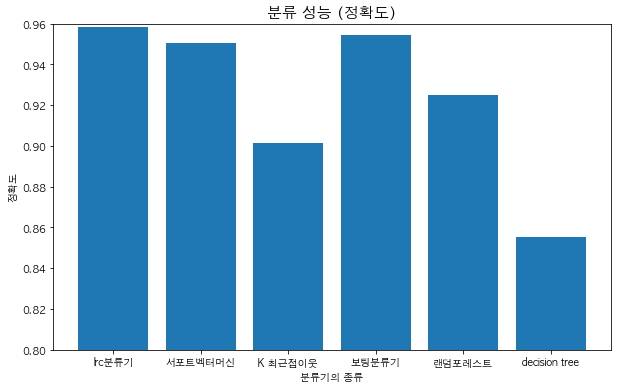

In [211]:
x = ['lrc분류기', '서포트벡터머신', 'K 최근접이웃', '보팅분류기', '랜덤포레스트', 'decision tree']
y = [0.958263, 0.950458, 0.901595, 0.95453, 0.925008, 0.855107]

plt.figure(figsize=(10,6))
plt.bar(x, y)
plt.xlabel('분류기의 종류')
plt.ylabel('정확도')
plt.ylim(0.8,0.96)
plt.rcParams['font.family'] = 'AppleGothic'
mpl.rcParams['axes.unicode_minus'] = False
plt.title('분류 성능 (정확도)', fontsize=15)
plt.show()

- 위의 표에 나타난 분류별 정확도를 보면, 로지스틱 회귀의 정확도가 가장 높게 나타난다.

- 여러 개의 기반 뷴류기를 결합한 보팅 분류기가 가장 높게 나올 줄 알았지만 그렇지 않은 걸로 보아,
여러 개의 분류기를 결합한다고 해서 무조건 예측 성능이 향성되는 건 아니라는 걸 알 수 있다.

- Decision tree는 과적합으로 인해 정확도가 가장 떨어진다.